## Midterm Project
### Team members:
Alen Adiyev, Zhamilya Saparova, Nuray Serkali


## **Introduction**

In this problem we implemented two techniques to implement two types of recommendation system. 

For the "Popular movies" we used Demographic Filtering to recommend the users uniform set of movies. This recommendation is not user-sensitive and uses the mean data.

With the Content-Based Filtering, to be precise, the analysis of the words in the descriptions of the movies, we created a model that recommends 10 similar movies, given a movie name. This recommendation system is somehow "user-sensitive", because it recommends different set of movies for different inputs.

The first dataset contains these features:

* movie_id - A unique identifier for each movie.
* cast - The name of lead and supporting actors.
* crew - The name of Director, Editor, Composer, Writer etc.

The second dataset has the features:

* budget - The budget in which the movie was made.
* genre - The genre of the movie, Action, Comedy ,Thriller etc.
* homepage - A link to the homepage of the movie.
* id - This is infact the movie_id as in the first dataset.
* keywords - The keywords or tags related to the movie.
* original_language - The language in which the movie was made.
* original_title - The title of the movie before translation or adaptation.
* overview - A brief description of the movie.
* popularity - A numeric quantity specifying the movie popularity.
* production_companies - The production house of the movie.
* production_countries - The country in which it was produced.
* release_date - The date on which it was released.
* revenue - The worldwide revenue generated by the movie.
* runtime - The running time of the movie in minutes.
* status - "Released" or "Rumored".
* tagline - Movie's tagline.
* title - Title of the movie.
* vote_average -  average ratings the movie recieved.
* vote_count - the count of votes recieved.

Dataset - https://www.kaggle.com/tmdb/tmdb-movie-metadata

In [ ]:
import pandas as pd 
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

# loading the data
df1 = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
df2 = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')

#joining the two dataset on the 'id' column
df1.columns = ['id','tittle','cast','crew']
df2 = df2.merge(df1,on='id')

# first 5 lines of the data
df2.head(5)

# **Demographic Data Analysis** -

We will use IMDB's weighted rating (wr) formula (IMDb publishes weighted vote averages rather than raw data averages):

Weighted Rating (wr) = (vR/(v+m))+(mC/(v+m))

* v - number of votes;
* m - minimum votes to be listed in the chart;
* R - average rating;
* C - mean vote for the all data

We know v and R, thus, we can calculate C:

In [ ]:
C= df2['vote_average'].mean()
print(C)

Next we need to determine m, the minimum votes to be listed in the chart. We will take 85% as threshold.So the movie's number of votes should be in the top 15% to be listed in a chart.

In [ ]:
m= df2['vote_count'].quantile(0.85)
print(m)

Now we will only leave the movies that qualify to be in the chart

In [ ]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
print(q_movies.shape)

The result shows that there are 481 movies that qualify to be in the chart. Now we need to calculate the score for each of these films. We will define a new feature **score** and a new function **weighted_rating()** by which we will calculate the score for the qualifies movies.

In [ ]:
def weighted_rating(x, m=m, C=C, v=v, R=R):
    v = x['vote_count']
    R = x['vote_average']
    
    # by the IMDB formula:
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# adding new feature **score**
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

Sorting the movies by their scores and showing the top 15 movies:

In [ ]:
#Sort movies 
q_movies = q_movies.sort_values('score', ascending=False)

#Printing the top 15
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(15)

This was the implementation of a recommender **Popular movies**

**Popular movies** recommender does not consider the user's interests into account and shows the same movies to all the users

Now we will implement Content-Based Filtering for a more defined recommendation system.

In [ ]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='g')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")


# **Content Based Filtering**

In this system a feature of the movies - description is used to determine the similar movies, so that we can recomment them later


## **Description based Recommender**


We compute the similarity of pair of movies based on their descriptions, description is given by the **overview** feature

In [ ]:
df2['overview'].head(5)

To get qualitative information from the **overview**, we will use the Frequency-Inverse Document Frequency (TF-IDF) vectors from scikit-learn.

In [ ]:
#Removing stop words
vectorizer = TfidfVectorizer(stop_words='english')

#checking for Nan
if (sum(df2.isnull().any()) > 0):
    df2 = df2.fillna('')
    print("\ndone.")
else:
    print("no Nan exist")

#Construct the required TF-IDF matrix by fitting and transforming the data
X = vectorizer.fit_transform(df2['overview'])

print(vectorizer.get_feature_names()[500:600])
print("\ndone.")

#Output the shape of tfidf_matrix
X.shape

This result means we have over 20,000 words describing 4803 movies

Next, we will use the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score as it is easier to calculate:
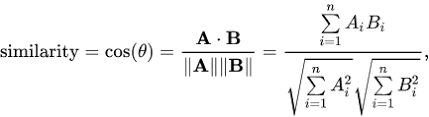

We will use scikit-learn's **cosine_similarity()** to calculate the similarity

In [ ]:
# Computing the cosine similarity matrix
cosine_sim = cosine_similarity(X, X)

#Constructing a reverse map of indices and movie titles
index = df2['title']
indices = pd.Series(df2.index, index).drop_duplicates()


Then we will define a function (recommend) that takes a movie's name and gives 10 similar movies. 
In order to implement this function:

1) we should be able to find the movie index by its name
2) we take a name of a move and output 10 similar movies

In [ ]:
def key(x):
    return x[1]

In [ ]:

def recommend(title, cosine_sim = cosine_sim):
    idx = indices[title]

    # Getting the list of similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sorting the similarity scores
    sim_scores = sorted(sim_scores, key = key, reverse = True)
    sim_scores = sim_scores[1:11]

    # Getting the movie indices
    indices_of_movies = [i[0] for i in sim_scores]

    # Returning the top 10 movies
    return df2['title'].iloc[indices_of_movies]


In [ ]:
recommend('Spider-Man 3')

In [ ]:
recommend('The Avengers')

In [ ]:
recommend('The Dark Knight Rises', cosine_sim2)

## **Conclusion** 
We created two recommenders: **Popular movies** and **Similar movies** by demographic and content-based analysis. 

Demographic analysis is more elementary, while content-based analysis can access the features, after which we can do some useful calculations to obtain qualitative information about the movie.

References:
1. [https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75](https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75)
2. [https://www.kaggle.com/rounakbanik/movie-recommender-systems](https://www.kaggle.com/rounakbanik/movie-recommender-systems)
3. https://www.kaggle.com/tmdb/tmdb-movie-metadata
